In [1]:
import igraph
import numpy as np
import json
import random
import pickle
import matplotlib.pyplot as plt

ImportError: No module named igraph

In [1]:
import numpy as np
import json
import random
import pickle
import matplotlib.pyplot as plt

In [131]:
skip1 = 0
data = {}
for line in open("san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv"):
    csv_row = line.split(',')
    if (skip1 == 1):
        if (csv_row[2] == '12'):
            #print (csv_row[0], csv_row[1], csv_row[3])
            k1 = int (csv_row[0])
            k2 = int(csv_row[1])
            if (k1 <= k2):
                key = (k1, k2)
            else:
                key = (k2, k1)
            if (not (key in data.keys())):
                data[key] = []
            data[key].append(float(csv_row[3]))                
    skip1 = 1
    
#['sourceid,dstid,month,mean_travel_time,standard_deviation_travel_time,geometric_mean_travel_time,geometric_standard_deviation_travel_time']

In [16]:
print (len(data))

321713


In [17]:
data_tup  = []
for k in data.keys():
    mean_wt = np.mean(data[k])
    data_tup.append((k[0],k[1], mean_wt))
    
#data_np = np.array(data_np)

In [18]:
len(data_tup)

321713

In [19]:
G = igraph.Graph.TupleList(data_tup, directed=False, weights=True)
print (G.summary())
print ("Number of Edges:    " , len(G.get_edgelist()))

IGRAPH UNW- 1905 321713 -- 
+ attr: name (v), weight (e)
Number of Edges:     321713


In [20]:
g_cluster = G.clusters()
print  (g_cluster.subgraph(0).summary())
print  (g_cluster.subgraph(1).summary())
print  (g_cluster.subgraph(2).summary())

IGRAPH UNW- 1898 321703 -- 
+ attr: name (v), weight (e)
IGRAPH UNW- 5 9 -- 
+ attr: name (v), weight (e)
IGRAPH UNW- 2 1 -- 
+ attr: name (v), weight (e)


In [21]:
g = g_cluster.giant()
print (g.summary())
print ("Number of Edges:    " , len(g.get_edgelist()))

IGRAPH UNW- 1898 321703 -- 
+ attr: name (v), weight (e)
Number of Edges:     321703


In [22]:
# Question 6
# Number of Edges = 321703
# Number of Vertices = 1898

In [23]:
with open('san_francisco_censustracts.json', 'r') as infile:  
    geo_data_j = json.load(infile)

In [24]:
vert_feat = {}
for i in range(len(geo_data_j['features'])):
    feat_i = geo_data_j['features'][i]
    m_id = feat_i['properties']['MOVEMENT_ID']
    disp_name = feat_i['properties']['DISPLAY_NAME']
    coors = np.mean(np.array(feat_i['geometry']['coordinates'][0][0]), axis = 0)
    vert_feat[int(m_id)] = (disp_name, coors.tolist())
    #print (m_id, disp_name, coors)

In [25]:
n_v = len(g.vs)
print ("Number of vertices: ", n_v)

for i in range(len(g.vs)):
    ind = g.vs[i]['name']
    g.vs[i]['disp_name'] = vert_feat[ind][0]
    g.vs[i]['coors'] = vert_feat[ind][1]

Number of vertices:  1898


In [28]:
mst = g.spanning_tree(weights = g.es["weight"])
print (mst.summary())

mst_edges = mst.get_edgelist()[:5]
print(mst_edges)

IGRAPH UNW- 1898 1897 -- 
+ attr: coors (v), disp_name (v), name (v), weight (e)
[(56, 57), (470, 471), (427, 500), (826, 838), (453, 961)]


In [ ]:
mst_cost = 0.0
for i in range(len(mst.es)):
    mst_cost += mst.es[i]['weight']
print (mst_cost)

In [29]:
for (e1,e2) in mst_edges:
    print (g.vs[e1]['disp_name'],'\n', g.vs[e2]['disp_name'])
    print (g.vs[e1]['coors'])
    print (g.vs[e2]['coors'])
    print (g.es[g.get_edgelist().index((e1,e2))]['weight']/60.0)
    print ('\n\n')

700 Lakeville Circle, Petaluma 
 7700 Lakeville Highway, Petaluma
[-122.59061477777777, 38.2394685]
[-122.54534531698114, 38.218784641509465]
3.7675



200 Ely Road North, Petaluma 
 2600 Goodwin Avenue, Penngrove
[-122.6473045952381, 38.27419766666666]
[-122.70315261643839, 38.31487776712328]
4.0785



Interstate 505, Vacaville 
 Sikes Road, Dixon
[-121.93828956060604, 38.3949288030303]
[-121.80871736619717, 38.464527415492945]
6.81775



3800 Mission Drive, Santa Cruz 
 1200 Rodriguez Street, Santa Cruz
[-121.97858992682927, 36.99728307317073]
[-121.98961930434781, 36.98288747826087]
2.706666666666666



19200 San Ramon Valley Boulevard, San Ramon 
 0 Mesa Vista Court, San Ramon
[-121.97724251515154, 37.745148575757554]
[-121.97494123076923, 37.76418646153845]
2.5449166666666665





In [94]:
edge_list = g.get_edgelist()
random.shuffle(edge_list)

In [96]:
vertices = []
#sorted_edges = []
for (e1, e2) in edge_list:
    if (not (e1 in vertices)):
        vertices.append(e1)
    if (not (e2 in vertices)):
        vertices.append(e2)
#     if (e1 > e2):
#         t = e1
#         e1 = e2
#         e2 = e1
#     sorted_edges.append((e1,e2))

In [97]:
len(vertices)

1898

In [98]:
def get_triangles(edge_list):
    triangles = []
    count = 0

    for (v1,v2) in edge_list:
        for v in vertices:
            if (count%100 == 0):
                print (count)
            if (count == 1000):
                return triangles
            
            if ((((v, v1) in edge_list) or ((v1, v) in edge_list)) and (((v, v2) in edge_list) or ((v2, v) in edge_list)) and (v != v1) and (v != v2)):
                count = count + 1
                triangles.append((v, v1, v2))

In [99]:
# triangles = get_triangles(edge_list)

0
0
0
100
100
100
100
100
100
100
100
200
200
300
400
400
400
500
600
700
800
800
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
900
1000


In [100]:
# f = open("triangles.txt", "wb")
# pickle.dump(triangles, f)

In [1]:
# f = open("triangles.txt", "rb")
# triangles2 = pickle.load(f)

In [ ]:
#edge_list = g.get_edgelist()
count = 0
for (v1,v2,v3) in triangles2:
    try:
        i1 = edge_list.index((v1,v2))
    except:
        i1 = edge_list.index((v2,v1))
        
    try:
        i2 = edge_list.index((v2,v3))
    except:
        i2 = edge_list.index((v3,v2))
        
    try:
        i3 = edge_list.index((v3,v1))
    except:
        i3 = edge_list.index((v1,v3))
        
    w1 = g.es[i1]['weight']
    w2 = g.es[i2]['weight']
    w3 = g.es[i3]['weight']
    
    if (((w1+w2) >= w3) and ((w2+w3) >= w1) and ((w3+w1) >= w2)):
        count = count + 1
        
print (count/10.0, "% of the triangles satisfy the triangle inequality.")

In [103]:
# Apply the 1-approximate algorithm

In [105]:
mst_double_edges = []
mst_edgelist = mst.get_edgelist()
for i in range(len(mst_edgelist)):
    wt = mst.es[i]['weight']
    (v1, v2) = mst_edgelist[i]
    mst_double_edges.append((mst.vs[v1]['name'], mst.vs[v2]['name'], wt))
    mst_double_edges.append((mst.vs[v1]['name'], mst.vs[v2]['name'], wt))
    
print (len(mst_edgelist))
print (len(mst_double_edges))

1897
3794


In [106]:
# Create two copies of each edge in MST
mst_d = igraph.Graph.TupleList(mst_double_edges, directed=False, weights=True)

In [107]:
# g_edges = [(1,2,1),(1,3,1),(2,3,1),(1,4,1), (4,5,1), (5,3,1), (1,6,1), (6,7,1), (7,8,1)]
# mst_edges = [(1,2,1),(1,3,1),(1,4,1),(5,3,1),(1,2,1),(1,3,1),(1,4,1),(5,3,1), (1,6,1), (6,7,1), (7,8,1)]
# g = igraph.Graph.TupleList(g_edges, directed=False, weights=True)
# mst_d = igraph.Graph.TupleList(mst_edges, directed=False, weights=True)

# print (g.get_edgelist())
# print (mst_d.get_edgelist())

In [108]:
n_v = len(mst_d.vs)
print ("Number of vertices in MST Double  : ", n_v)
print ("Number of edges in MST Double     : ", len(mst_d.es))
print ("Number of edges in MST            : ", len(mst.es))

for i in range(len(mst_d.vs)):
    ind = mst_d.vs[i]['name']
    mst_d.vs[i]['disp_name'] = vert_feat[ind][0]
    mst_d.vs[i]['coors'] = vert_feat[ind][1]

Number of vertices in MST Double  :  1898
Number of edges in MST Double     :  3794
Number of edges in MST            :  1897


In [109]:
# Find a eulerian walk of that
count = 0
n_v = len(mst_d.vs)
mst_d_edgelist = mst_d.get_edgelist()
path = []
curr = mst_d_edgelist[0][0]
start = curr
vertices = [curr]
edges_remaining = list.copy(mst_d_edgelist)

In [110]:
count = 1
curr_n = -1
while (count < n_v):
    for (v1,v2) in edges_remaining:
        if ((v1 == curr and (not (v2 in vertices))) or (v2 == curr and (not (v1 in vertices)))):
#             if (count%10 == 0):
#                 print (count, '/', n_v)
            edges_remaining.remove((v1,v2))
            path.append((v1,v2))
            if (v1 == curr):
                if (not (v2 in vertices)):
                    vertices.append(v2)
                    count += 1
                curr_n = v2
            if (v2 == curr):
                if (not (v1 in vertices)):
                    vertices.append(v1)
                    count += 1
                curr_n = v1
            break
    if (curr == curr_n):
        for (v1,v2) in edges_remaining:
            if ((v1 == curr) or (v2 == curr)):
#                 if (count%10 == 0):
#                     print (count, '/', n_v)
                edges_remaining.remove((v1,v2))
                path.append((v1,v2))
                if (v1 == curr):
                    if (not (v2 in vertices)):
                        vertices.append(v2)
                        count += 1
                    curr_n = v2
                if (v2 == curr):
                    if (not (v1 in vertices)):
                        vertices.append(v1)
                        count += 1
                    curr_n = v1
                break
    if (curr == curr_n):
        print ("Error Condition")
    curr = curr_n

print (curr, start)

for (v1,v2) in edges_remaining:
        if (v1 == curr and v2 == start):
            edges_remaining.remove((v1,v2))
            path.append((v1,v2))
            vertices.append(start)
        if (v1 == start and v2 == curr):
            edges_remaining.remove((v1,v2))
            path.append((v1,v2))
            vertices.append(start)


817 0


In [111]:
def convert_vertex_index(vertices, g, mst):
    vertices_n = []
    for v in vertices:
        n = mst.vs[v]['name']
        for i in range(len(g.vs)):
            if (n == g.vs[i]['name']):
                vertices_n.append(i)
    return vertices_n


def convert_path_index(path, g, mst):
    path_n = []
    for (v1, v2) in path:
        n1 = mst.vs[v1]['name']
        n2 = mst.vs[v2]['name']
        ind1 = -1
        ind2 = -1
        for i in range(len(g.vs)):
            if (n1 == g.vs[i]['name']):
                ind1 = i
            if (n2 == g.vs[i]['name']):
                ind2 = i
        path_n.append((ind1, ind2))
    return path_n

In [112]:
vertices_g = convert_vertex_index(vertices, g, mst_d)
path_g = convert_path_index(path, g, mst_d)

In [113]:
first_mentions = {}
for v in vertices_g:
    for i in range(len(path_g)):
        (e1,e2) = path_g[i]
        if (e1 == v or e2 == v):
            first_mentions[v] = i
            break

In [114]:
path_trimmed = []
cost = 0.0
vertices_visited = []

g_edgelist = g.get_edgelist()

for i in range(0, len(vertices)-1):
    v = vertices[i]
    n_v = vertices[i+1]
    
    v_g = vertices_g[i]
    n_v_g = vertices_g[i+1]
    
    if (not (n_v_g in vertices_visited)):    
        if ((v,n_v) in mst_d_edgelist):
            #print ("Direct edge from mst: ", v, n_v)
            path_trimmed.append((v_g,n_v_g))
            cost += mst_d.es[mst_d_edgelist.index((v,n_v))]['weight']
        elif ((n_v,v) in mst_d_edgelist):
            #print ("Direct edge from mst: ", n_v, v)
            path_trimmed.append((n_v_g,v_g))
            cost += mst_d.es[mst_d_edgelist.index((n_v,v))]['weight']
        elif ((v_g,n_v_g) in g_edgelist):
            #print ("Direct edge from g: ", v_g, n_v_g)
            path_trimmed.append((v_g,n_v_g))
            cost += g.es[g_edgelist.index((v_g,n_v_g))]['weight']
        elif ((n_v_g,v_g) in g_edgelist):
            #print ("Direct edge from g: ", n_v_g, v_g)
            path_trimmed.append((n_v_g,v_g))
            cost += g.es[g_edgelist.index((n_v_g,v_g))]['weight']
#         else:
#             e_list = g.get_shortest_paths(v_g, to=n_v_g, weights='weight', output="epath")
#             v_list = g.get_shortest_paths(v_g, to=n_v_g, weights='weight', output="vpath")
#             for e in e_list[0]:
#                 path_trimmed.append(g_edgelist[e])
#                 cost += g.es[e]['weight']
#             for v in v_list:
#                 vertices_visited.append(v)
        else:
            for i in range(first_mentions[v_g]+1, first_mentions[n_v_g]+1):
                if (path_g[i] in g_edgelist):
                    path_trimmed.append(path_g[i])
                    cost += g.es[g_edgelist.index(path_g[i])]['weight']
                else:
                    opp_e = (path_g[i][1], path_g[i][0])
                    path_trimmed.append(opp_e)
                    cost += g.es[g_edgelist.index(opp_e)]['weight']
        vertices_visited.append(v_g)
        vertices_visited.append(n_v_g)



            
print ("Cost of Approx. TSP = ", cost)

Cost of Approx. TSP =  503305.67500000104


In [115]:
# With Shortest Path Addition
path_trimmed_sp = []
cost_sp = 0.0
vertices_visited = []

g_edgelist = g.get_edgelist()

for i in range(0, len(vertices)-1):
    v = vertices[i]
    n_v = vertices[i+1]
    
    v_g = vertices_g[i]
    n_v_g = vertices_g[i+1]
    
    if (not (n_v_g in vertices_visited)):    
        if ((v,n_v) in mst_d_edgelist):
            #print ("Direct edge from mst: ", v, n_v)
            path_trimmed_sp.append((v_g,n_v_g))
            cost_sp += mst_d.es[mst_d_edgelist.index((v,n_v))]['weight']
        elif ((n_v,v) in mst_d_edgelist):
            #print ("Direct edge from mst: ", n_v, v)
            path_trimmed_sp.append((n_v_g,v_g))
            cost_sp += mst_d.es[mst_d_edgelist.index((n_v,v))]['weight']
        elif ((v_g,n_v_g) in g_edgelist):
            #print ("Direct edge from g: ", v_g, n_v_g)
            path_trimmed_sp.append((v_g,n_v_g))
            cost_sp += g.es[g_edgelist.index((v_g,n_v_g))]['weight']
        elif ((n_v_g,v_g) in g_edgelist):
            #print ("Direct edge from g: ", n_v_g, v_g)
            path_trimmed_sp.append((n_v_g,v_g))
            cost_sp += g.es[g_edgelist.index((n_v_g,v_g))]['weight']
        else:
            e_list = g.get_shortest_paths(v_g, to=n_v_g, weights='weight', output="epath")
            v_list = g.get_shortest_paths(v_g, to=n_v_g, weights='weight', output="vpath")
            for e in e_list[0]:
                path_trimmed_sp.append(g_edgelist[e])
                cost_sp += g.es[e]['weight']
            for v in v_list:
                vertices_visited.append(v)
#         else:
#             for i in range(first_mentions[v_g]+1, first_mentions[n_v_g]+1):
#                 if (path_g[i] in g_edgelist):
#                     path_trimmed.append(path_g[i])
#                     cost += g.es[g_edgelist.index(path_g[i])]['weight']
#                 else:
#                     opp_e = (path_g[i][1], path_g[i][0])
#                     path_trimmed.append(opp_e)
#                     cost += g.es[g_edgelist.index(opp_e)]['weight']
                    
        vertices_visited.append(v_g)
        vertices_visited.append(n_v_g)



            
print ("Cost of Approx. TSP = ", cost_sp)

Cost of Approx. TSP =  480757.3550000006


In [116]:
print(len(path), len(path_trimmed) ,len(path_trimmed_sp))

3784 2304 2014


In [117]:
# Path Cost
cost_path = 0.0
for e in path:
    cost_path += mst_d.es[mst_d.get_edgelist().index(e)]['weight']
    
print ('Cost of Path                  : ', cost_path)
print ('Cost of Path Trimmed          : ', cost)
print ('Cost of Path Trimmed with SP  : ', cost_sp)

Cost of Path                  :  576581.5350000007
Cost of Path Trimmed          :  503305.67500000104
Cost of Path Trimmed with SP  :  480757.3550000006


In [118]:
# Find an upper bound on the empirical performance of the approximate algorithm:
# rho = Approximate TSP Cost/Optimal TSP Cost

In [119]:
path_vertices = [path_trimmed[0][0]]
for (v1, v2) in path_trimmed:
    if (not (v2 in path_vertices)):
        path_vertices.append(v2)

In [120]:
for v in path_vertices[:10]:
    print(g.vs[v]['disp_name'])

700 Lakeville Circle, Petaluma
7700 Lakeville Highway, Petaluma
1800 Marshall Petaluma Road, Petaluma
John Slough, Novato
300 Olive Avenue, Novato
100 Sequoia Glen Lane, Novato
0 Pinheiro Circle, Novato
Middle Burdell Fire Road, Novato
0 Nova Lane, Novato
0 Black Oak Lane, Novato


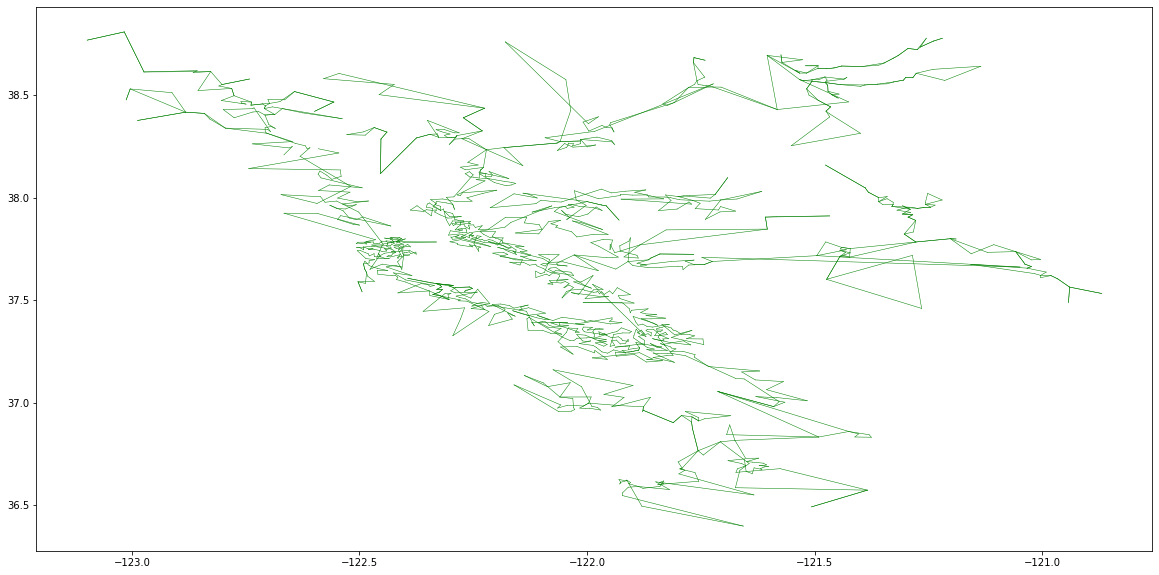

In [125]:
# Plot the trajectory that Santa has to travel!

x = [g.vs[path_trimmed[0][0]]['coors'][0]]
y = [g.vs[path_trimmed[0][0]]['coors'][1]]

for (v1,v2) in path_trimmed:
    x.append(g.vs[v2]['coors'][0])
    y.append(g.vs[v2]['coors'][1])

plt.figure(figsize=(20,10))
for i in range(0,len(x)-1):
    plt.plot(x[i:i+2],y[i:i+2], 'go-', linewidth=0.5, ms=0)

plt.show()

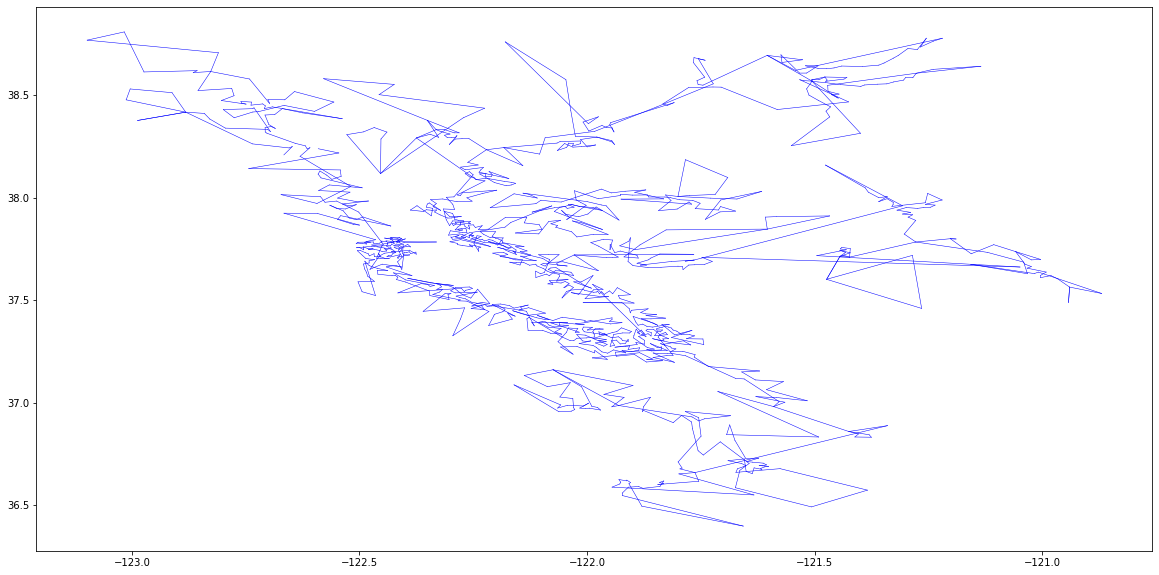

In [126]:
# Plot the trajectory that Santa has to travel with Shortest Path!

x = [g.vs[path_trimmed_sp[0][0]]['coors'][0]]
y = [g.vs[path_trimmed_sp[0][0]]['coors'][1]]

for (v1,v2) in path_trimmed_sp:
    x.append(g.vs[v2]['coors'][0])
    y.append(g.vs[v2]['coors'][1])

plt.figure(figsize=(20,10))
for i in range(0,len(x)-1):
    plt.plot(x[i:i+2],y[i:i+2], 'bo-', linewidth=0.5, ms=0)

plt.show()

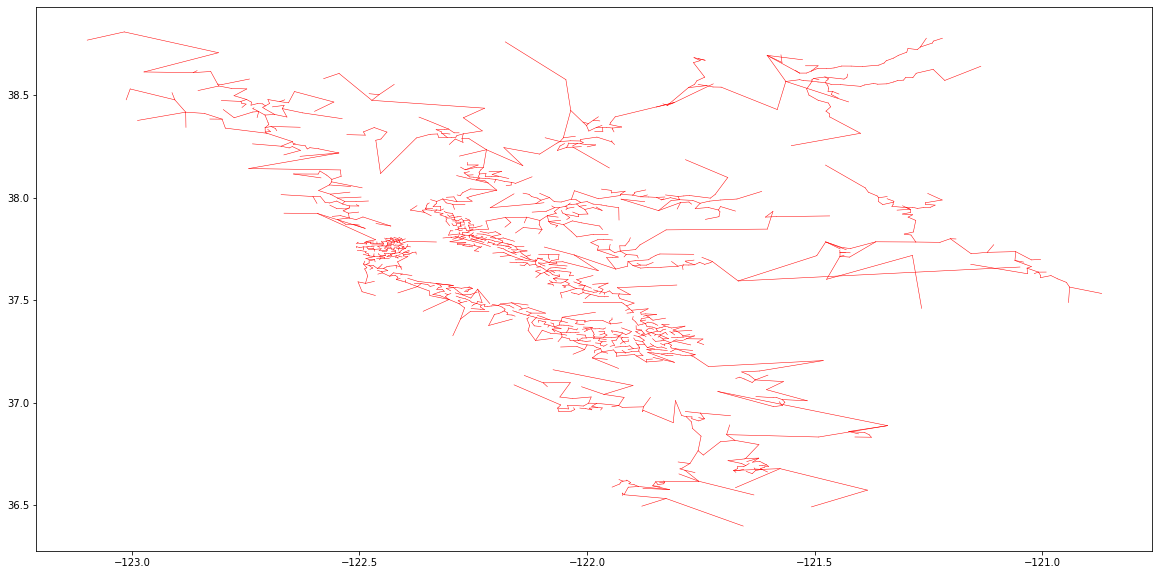

In [129]:
# Printing the MST
plt.figure(figsize=(20,10))

for (v1, v2) in mst.get_edgelist():
    x1,y1 = mst.vs[v1]['coors']
    x2,y2 = mst.vs[v2]['coors']
    plt.plot([x1, x2],[y1, y2], 'ro-', linewidth=0.5, ms=0)
plt.show()

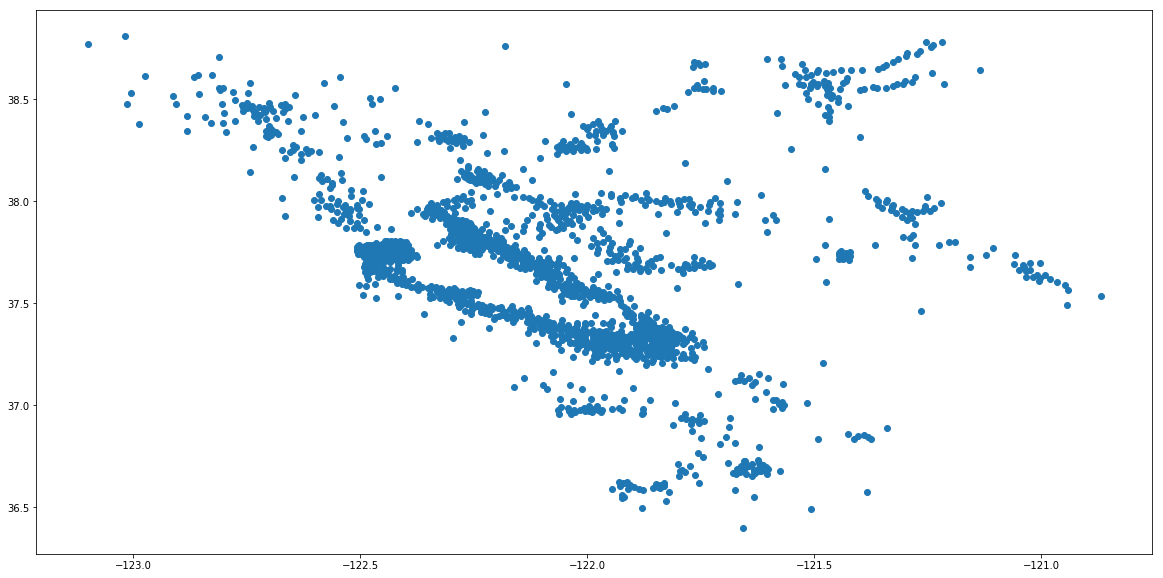

In [47]:
x = []
y= []
for v in g.vs:
    x.append(v['coors'][0])
    y.append(v['coors'][1])
    
plt.figure(figsize=(20,10))
plt.scatter(x,y)

In [6]:
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h',
            lat_0 = 37.7749, lon_0 = 122.4194,
            width=1E3, height=1.2E3)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

for i in range(0,len(x)-1):
    m.plot(x[i:i+2],y[i:i+2], 'go-', linewidth=0.5, ms=0)

/home/asavari/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys


ImportError: warpimage method requires PIL (http://pillow.readthedocs.io)

<Figure size 576x576 with 0 Axes>

In [140]:
g.vs[57]

igraph.Vertex(<igraph.Graph object at 0x7f953ba6ae58>, 57, {'name': 834, 'disp_name': '7700 Lakeville Highway, Petaluma', 'coors': [-122.54534531698114, 38.218784641509465]})

In [142]:
with open('path.csv', 'w') as f:
    f.write('Longitude, Latitude, Line Group (Path ID), Order of Points \n')
    # first node
    loc = g.vs[path_trimmed[0][0]]['coors']
    f.write(str(loc[0]) + ', ' + str(loc[1]) + ', ' + '1, 1 \n')
    order = 2
    for (v1,v2) in path_trimmed[1:]:
        location = g.vs[v2]['coors']
        f.write(str(location[0]) + ', ' + str(location[1]) + ', ' + '1, ' + str(order) + '\n')
        order += 1